<a href="https://colab.research.google.com/github/chindyfebryan/FlavourFinder/blob/main/model_with_MobileNet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!kaggle datasets download -d very133/dataset-flavourfinder

Dataset URL: https://www.kaggle.com/datasets/very133/dataset-flavourfinder
License(s): Community Data License Agreement - Sharing - Version 1.0
 91% 89.0M/97.4M [00:00<00:00, 133MB/s]
100% 97.4M/97.4M [00:00<00:00, 130MB/s]


In [3]:
!unzip dataset-flavourfinder.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Dataset/chilies/Image_62_jpg.rf.90a6f87102eb94f48c2c06a7cb5fff3a.jpg  
  inflating: Dataset/chilies/Image_62_jpg.rf.f9096e87a94017c3b3a418af65446e3f.jpg  
  inflating: Dataset/chilies/Image_632_jpg.rf.3cd54591dee3eab07c61146f9099c9b5.jpg  
  inflating: Dataset/chilies/Image_632_jpg.rf.4c9506e70cff8df6cf46331b938c4789.jpg  
  inflating: Dataset/chilies/Image_632_jpg.rf.6e705a6ea448e5b33fa3b577f46d5e12.jpg  
  inflating: Dataset/chilies/Image_633_jpg.rf.a2eeee9adc15820723a1fdbc5a379e3d.jpg  
  inflating: Dataset/chilies/Image_633_jpg.rf.ce896b91aff52713cd75ab156cd4ee34.jpg  
  inflating: Dataset/chilies/Image_633_jpg.rf.ef289b9a6c8fddca5ab274db72591d63.jpg  
  inflating: Dataset/chilies/Image_634_jpg.rf.411c6fd79188fb4dc1a8d31b52639156.jpg  
  inflating: Dataset/chilies/Image_634_jpg.rf.b9c7c96a4f2a2d0dd435750ffd50b7a5.jpg  
  inflating: Dataset/chilies/Image_634_jpg.rf.fabe7cf7d1c838f542243a1a4154497a.jpg  
  inflat

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "/content/Dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 12915 files belonging to 8 classes.
Using 10332 files for training.
Found 12915 files belonging to 8 classes.
Using 2583 files for validation.


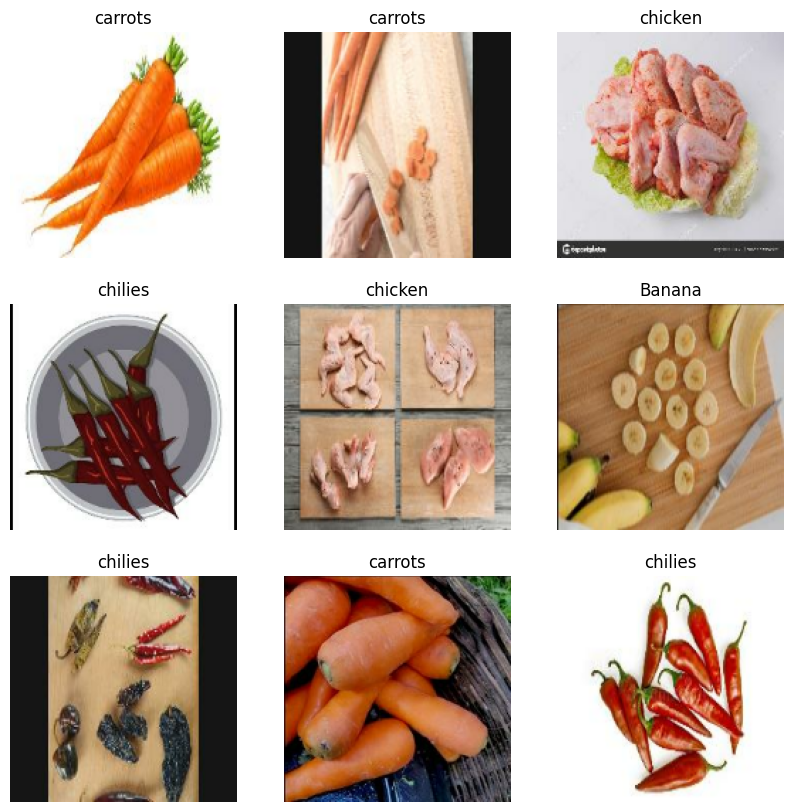

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [16]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))

    return data_augmentation

In [17]:
augmenter = data_augmenter()

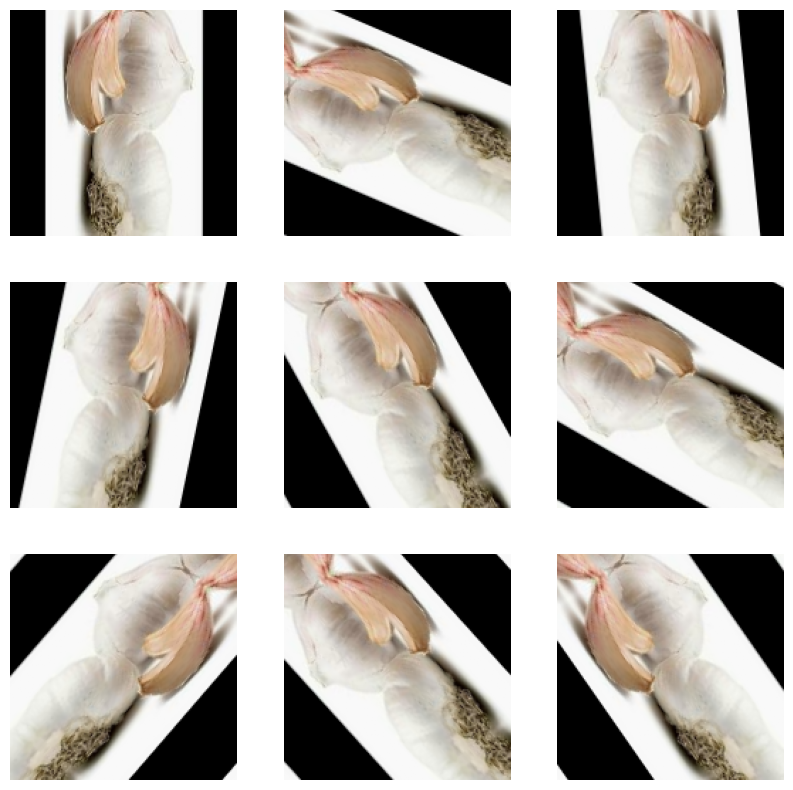

In [18]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [19]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [20]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [21]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [22]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_1
predictions


In [23]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [24]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 1, 2, 1, 6, 0, 5, 5, 2, 2, 2, 6, 0, 6, 4, 5, 2, 4, 2, 4, 0,
       1, 5, 1, 2, 2, 4, 2, 6, 1, 2], dtype=int32)>

In [25]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04332243', 'strainer', 0.5377993),
  ('n04589890', 'window_screen', 0.035755526)],
 [('n04548280', 'wall_clock', 0.04156126),
  ('n02708093', 'analog_clock', 0.036021)],
 [('n03998194', 'prayer_rug', 0.097532384),
  ('n03530642', 'honeycomb', 0.05545157)],
 [('n03530642', 'honeycomb', 0.3602191),
  ('n04507155', 'umbrella', 0.03504044)],
 [('n04589890', 'window_screen', 0.58909374),
  ('n03347037', 'fire_screen', 0.05775426)],
 [('n04589890', 'window_screen', 0.3841023),
  ('n03530642', 'honeycomb', 0.08425731)],
 [('n04039381', 'racket', 0.33989453), ('n03692522', 'loupe', 0.06439622)],
 [('n04589890', 'window_screen', 0.8050893),
  ('n01773549', 'barn_spider', 0.008910523)],
 [('n04589890', 'window_screen', 0.10949948),
  ('n03347037', 'fire_screen', 0.10063475)],
 [('n03530642', 'honeycomb', 0.49589708),
  ('n04589890', 'window_screen', 0.09278959)],
 [('n03530642', 'honeycomb', 0.3531399),
  ('n03598930', 'jigsaw_puzzle', 0.101579435)],
 [('n04008634', 'projectile', 0.27904776

In [39]:
def ingredient_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):

    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)

    prediction_layer = tfl.Dense(8, activation='softmax')

    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [40]:
model2 = ingredient_model(IMG_SIZE, data_augmentation)

In [41]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [42]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


323/323 [==============================] - 18s 46ms/step - loss: 0.5466 - accuracy: 0.8205 - val_loss: 0.2463 - val_accuracy: 0.9249
Epoch 2/5
323/323 [==============================] - 12s 37ms/step - loss: 0.2599 - accuracy: 0.9117 - val_loss: 0.1949 - val_accuracy: 0.9388
Epoch 3/5
323/323 [==============================] - 13s 41ms/step - loss: 0.2164 - accuracy: 0.9272 - val_loss: 0.1754 - val_accuracy: 0.9477
Epoch 4/5
323/323 [==============================] - 12s 37ms/step - loss: 0.1886 - accuracy: 0.9357 - val_loss: 0.1676 - val_accuracy: 0.9493
Epoch 5/5
323/323 [==============================] - 12s 38ms/step - loss: 0.1721 - accuracy: 0.9402 - val_loss: 0.1558 - val_accuracy: 0.9508


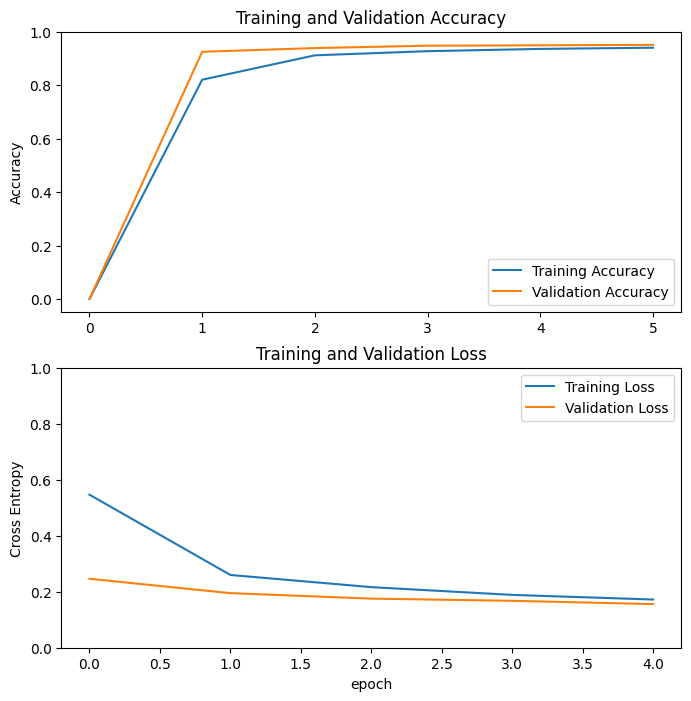

In [43]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()